# Setup Notebook

In [1]:
!pip install sktime==0.10.0 pmdarima tbats prophet

     |████████████████████████████████| 6.4 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 604 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 7.8 MB/s  eta 0:00:01
     |████████████████████████████████| 2.3 MB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 983 kB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 7.8 MB/s  eta 0:00:01
     |████████████████████████████████| 16.2 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 4.6 MB/s eta 0:00:011
     |████████████████████████████████| 172 kB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 8.2 MB/s  eta 0:00:01
     |████████████████████████████████| 46 kB 8.6 MB/s  eta 0:00:01
  Using cached PyMeeus-0.5.11-py3-none-any.whl
  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_scaled_error

Importing plotly failed. Interactive plots will not work.


# Bike Sharing Data

In [4]:
file = './data/bikes/hour.csv'

df = pd.read_csv(file)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df['datetime'] = pd.to_datetime(df['dteday'].astype(str) + ' ' + df['hr'].astype(str) + ":00")

df.set_index('datetime', inplace=True)

print(f"from {min(df.index)} to {max(df.index)}")

from 2011-01-01 00:00:00 to 2012-12-31 23:00:00


Fill missing fields with interpolated values. This is not ideal.

In [8]:
index = pd.date_range(min(df.index), max(df.index), freq='H')
int_columns = df.select_dtypes(include=['int64']).columns

df_i = df.reindex(index)

# turn the int columns to float
df_i[int_columns] = df_i[int_columns].astype(float)

# interpolate
df_i = df_i.interpolate(axis=0)

# turn the columns back to int
df_i[int_columns] = df_i[int_columns].astype(int)

df_i.loc[df_i['dteday'].isna(), 'dteday'] = df_i[df_i['dteday'].isna()].index.strftime('%Y-%m-%d').tolist()
df = df_i


In [9]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
2012-12-31 20:00:00,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
2012-12-31 21:00:00,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
2012-12-31 22:00:00,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


Plot last 10 days.

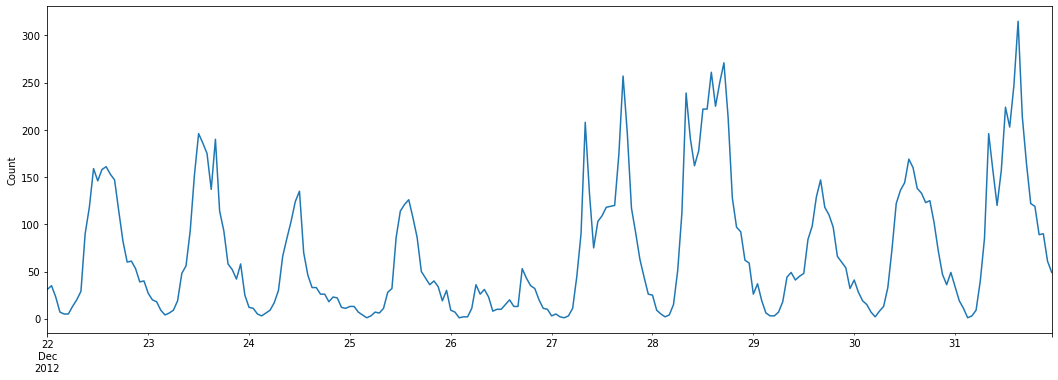

In [11]:
plt.figure(figsize=(18, 6))
df[-240:]['cnt'].plot()
# df.tail(10)['cnt'].plot()
_ = plt.xlabel('')
_ = plt.ylabel('Count')

Plot daily data.

In [7]:
df_per_day = df['cnt'].groupby([df.index.floor('d')]).sum()
df_per_day = df_per_day.asfreq('D', method='bfill')
df_per_day.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', length=731, freq='D')

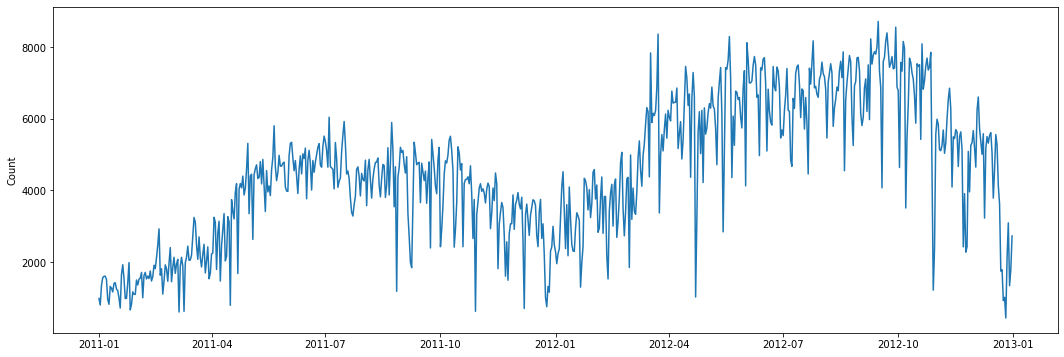

In [8]:
plt.figure(figsize=(18, 6))
sns.lineplot(data=df_per_day)
_ = plt.xlabel('')
_ = plt.ylabel('Count')

In working days the highest usage is during peak hours, while in non-working days it is at noon.

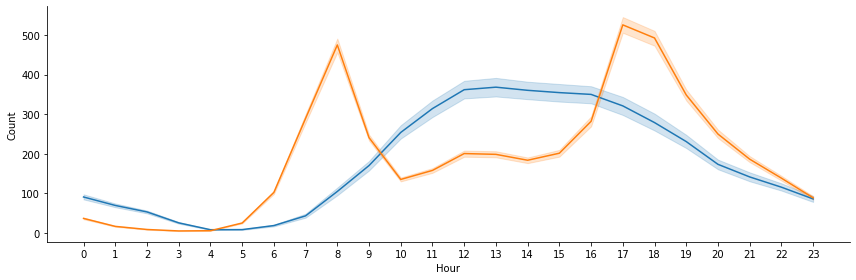

In [9]:
grid = sns.FacetGrid(df, height=4.0, aspect=3.0)

grid.map_dataframe(sns.lineplot, x="hr", y="cnt", hue='workingday')

plt.xticks(range(24))
_ = plt.xlabel('Hour')
_ = plt.ylabel('Count')

Quite a difference in usage rate between the first and second year.

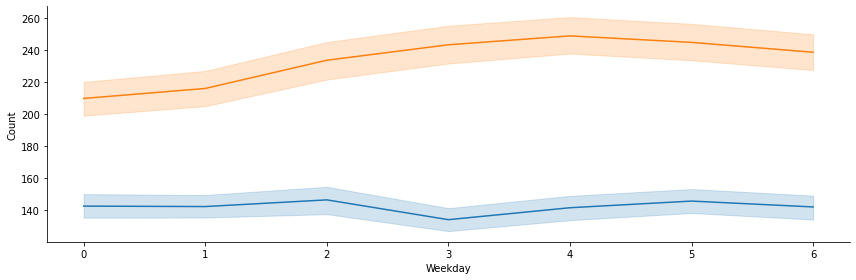

In [10]:
grid = sns.FacetGrid(df, height=4.0, aspect=3.0)
grid.map_dataframe(sns.lineplot, x="weekday", y="cnt", hue='yr')
plt.xticks(range(7))
_ = plt.xlabel('Weekday')
_ = plt.ylabel('Count')

Less bikes are rented during winter.

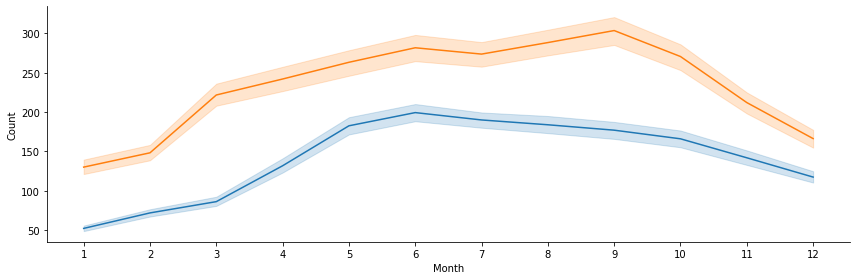

In [11]:
grid = sns.FacetGrid(df, height=4.0, aspect=3.0)
grid.map_dataframe(sns.lineplot, x="mnth", y="cnt", hue='yr')
plt.xticks(range(1,13))
_ = plt.xlabel('Month')
_ = plt.ylabel('Count')

Naturally, weather conditions have an effect.

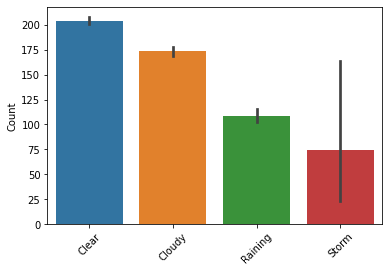

In [12]:
ax = sns.barplot(data=df, x="weathersit", y="cnt")
ax.set_xticklabels(['Clear', 'Cloudy', 'Raining', 'Storm'], rotation=45)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Count')

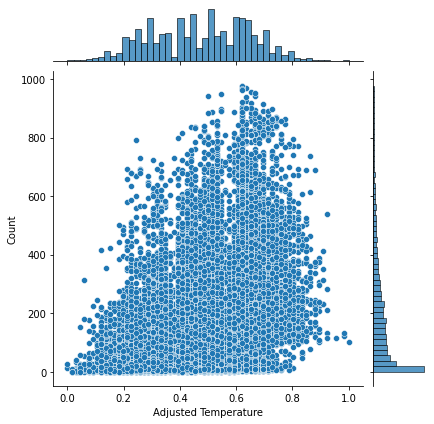

In [13]:
_ = sns.jointplot(data=df, x="atemp", y="cnt").set_axis_labels(xlabel='Adjusted Temperature', ylabel='Count')

# Forecasts

We will use 168 hour seasons for models that do not support complex seasonality.

In [14]:
# 168 hours in a season
season = 7*24

In [15]:
y = df['cnt'].astype(float)

In [16]:
start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2012-07-01')

y_train = y[(y.index >= start_date) & (y.index < end_date)]

In [17]:
forecasters = {
  #'Mean' : NaiveForecaster(strategy='mean'),
  #'Drift' : NaiveForecaster(strategy='drift'),
  'Seasonal Naive' : NaiveForecaster(strategy='last', sp=season),
  #'ARIMA' : ARIMA(order=(2, 1, 2), seasonal_order=(2, 1, 2, 24), suppress_warnings=True),
  #'Auto ARIMA' : AutoARIMA(sp=season, start_p=1, start_q=1, max_p=1, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1, suppress_warnings=True),
  'Exponential Smoothing' : ExponentialSmoothing(trend='add', seasonal='additive', sp=season, damped_trend=True),
  #'Auto ETS' : AutoETS(trend='add', seasonal='additive', sp=season),
  #'BATS' : BATS(use_box_cox=False, use_trend=True, sp=[season, 24], use_arma_errors=False, n_jobs=1),
  #'TBATS' : TBATS(use_box_cox=False, use_trend=True, sp=[season, 24], use_arma_errors=False, n_jobs=1),
  'Prophet' : Prophet(yearly_seasonality=False),
  }

Fit forecasters:

In [18]:
for forecaster_name, forecaster in forecasters.items():
  forecaster.fit(y_train)

In [19]:
def performance_metrics(y_test, y_preds):
  metrics = {
    'MAE' : mean_absolute_error,
    'RMSE' : (lambda y, y_pred : mean_squared_error(y, y_pred, square_root=True)),
    'MAPE' : mean_absolute_percentage_error,
    'MASE' : (lambda y, y_pred : mean_absolute_scaled_error(y, y_pred, y_train=y_train)),  
  }

  df_performance_metrics = pd.DataFrame(columns=list(metrics.keys()))

  for forecaster_name, y_pred in y_preds.items():
    metrics_values = {}
    for metric_name, metric in metrics.items():
      value = metric(y_test, y_pred)
      metrics_values[metric_name] = value

    df_performance_metrics = df_performance_metrics.append(pd.Series(metrics_values, name=forecaster_name))

  return df_performance_metrics

# 1 Day Forecast

In [20]:
forecast_date = end_date + pd.DateOffset(days=1)
y_test = y[(y.index >= end_date) & (y.index < forecast_date)]

In [21]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

y_preds = {}

for forecaster_name, forecaster in forecasters.items():
  y_pred = forecaster.predict(fh)
  y_preds[forecaster_name] = y_pred

# add ensembled forecast
y_pred = sum(list(y_preds.values())) / len(y_preds)
y_preds['Ensemble'] = y_pred

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:499: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:509: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:67: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:70: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/usr/local/lib/python3.7/

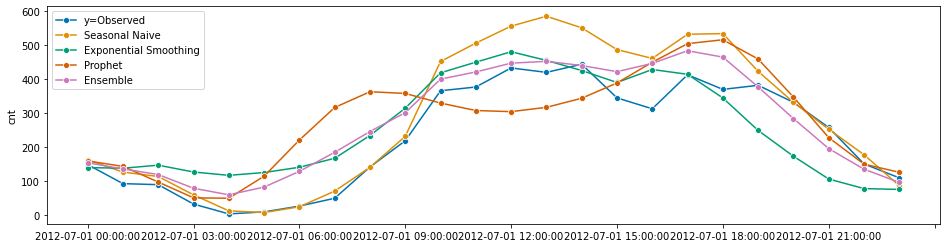

In [22]:
fig, ax = plot_series(y_test, *tuple(y_preds.values()), labels=['y=Observed'] + list(y_preds.keys()))

In [23]:
performance_metrics(y_test, y_preds)

,MAE,RMSE,MAPE,MASE
Seasonal Naive,59.416667,83.488023,0.255697,0.801688
Exponential Smoothing,75.750552,87.825602,0.537309,1.022075
Prophet,85.563790,110.695468,0.477585,1.154481
Ensemble,55.257272,67.224664,0.420236,0.745566


# 1 Week Forecast

In [24]:
forecast_date = end_date + pd.DateOffset(weeks=1)
y_test = y[(y.index >= end_date) & (y.index < forecast_date)]

In [25]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

y_preds = {}

for forecaster_name, forecaster in forecasters.items():
  y_pred = forecaster.predict(fh)
  y_preds[forecaster_name] = y_pred

# add ensembled forecast
y_pred = sum(list(y_preds.values())) / len(y_preds)
y_preds['Ensemble'] = y_pred

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:499: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:509: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:67: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:70: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/usr/local/lib/python3.7/

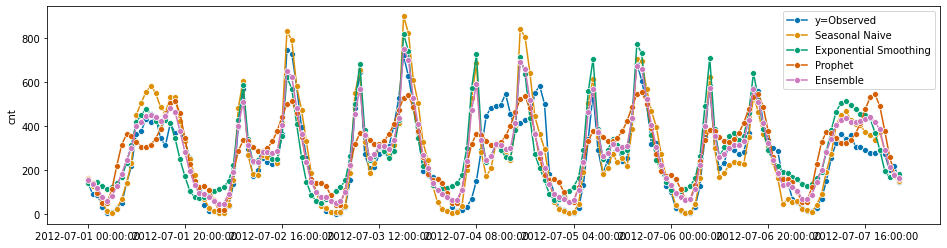

In [26]:
fig, ax = plot_series(y_test, *tuple(y_preds.values()), labels=['y=Observed'] + list(y_preds.keys()))

In [27]:
performance_metrics(y_test, y_preds)

,MAE,RMSE,MAPE,MASE
Seasonal Naive,66.886905,108.374873,0.296521,0.902481
Exponential Smoothing,95.315603,126.243878,0.539323,1.286059
Prophet,90.817189,115.610590,0.500178,1.225363
Ensemble,70.395651,97.789840,0.449168,0.949823


# 1 Month Forecast

In [28]:
forecast_date = end_date + pd.DateOffset(months=1)
y_test = y[(y.index >= end_date) & (y.index < forecast_date)]

In [29]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

y_preds = {}

for forecaster_name, forecaster in forecasters.items():
  y_pred = forecaster.predict(fh)
  y_preds[forecaster_name] = y_pred

# add ensembled forecast
y_pred = sum(list(y_preds.values())) / len(y_preds)
y_preds['Ensemble'] = y_pred

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:499: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:509: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:67: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/lib/python3.7/dist-packages/sktime/utils/datetime.py:70: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/usr/local/lib/python3.7/

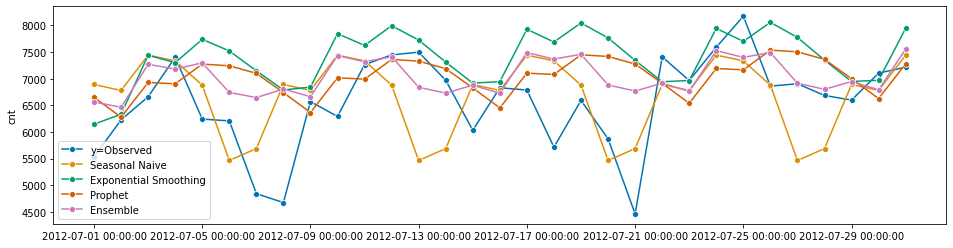

In [30]:
y_test_per_day = y_test.groupby(y_test.index.date).sum()
y_test_per_day.index = pd.to_datetime(y_test_per_day.index)
y_preds_per_day = {}
for forecaster_name, y_pred in y_preds.items():
  y_preds_per_day[forecaster_name] = y_pred.groupby(y_pred.index.date).sum()
  y_preds_per_day[forecaster_name].index = pd.to_datetime(y_preds_per_day[forecaster_name].index)

fig, ax = plot_series(y_test_per_day, *tuple(y_preds_per_day.values()), labels=['y=Observed'] + list(y_preds_per_day.keys()))

In [31]:
performance_metrics(y_test, y_preds)

,MAE,RMSE,MAPE,MASE
Seasonal Naive,50.657258,81.948540,0.249264,0.683500
Exponential Smoothing,89.495243,109.519455,0.535292,1.207527
Prophet,104.253342,132.676849,0.542584,1.406653
Ensemble,70.182601,88.798026,0.459873,0.946948


The seasonal naive model seems to be a good benchmark for this series. Ensembling different models can help produce more accurate forecasts.

Q: Why does ARIMA need so much time to fit the data when the period is large? Maybe the time needed to compute the loss function depends heavily on this parameter?